In [1071]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as leg

Set up classes

In [1072]:
class particle:
     def __init__(self, alive, mu, x, g, w):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.g = g
        self.w = w

In [1073]:
class source:
    def __init__(self, scatter, fission):
        self.scatter = scatter
        self.fission = fission

In [1074]:
class tally:
    def __init__(self, cell_average_flux, cell_edge_flux, current, k):
        self.cell_average_flux = cell_average_flux
        self.cell_edge_flux = cell_edge_flux
        self.current = current
        self.k = k
    
    def zero_g(self, g):
        self.cell_average_flux[:, g] *= 0
        self.cell_edge_flux[:, g] *= 0
        self.current[:, g] *= 0

    def zero(self):
        self.cell_average_flux *= 0
        self.cell_edge_flux *= 0
        self.current *= 0

In [1075]:
class material:
    def __init__(self, nuSigmaF, SigmaS, SigmaT):
        self.nuSigmaF = nuSigmaF
        self.SigmaS = SigmaS
        self.SigmaT = SigmaT

In [1076]:
class cell:
    def __init__(self, left, right, material):
        self.left = left
        self.right = right
        self.material = material

In [1077]:
class mesh:
    def __init__(self, Nx, L, bc, U, W):
        self.Nx = Nx
        self.L = L
        self.dx = L/(Nx-1)
        self.mesh_x = np.linspace(0, L, Nx)
        self.mesh_flux = np.linspace(0, L, Nx-1)
        self.bc = bc
        self.U = U
        self.W = W

In [1078]:
class bc:
    def __init__(self, bc):
        self.bc = bc

Set up functions

In [1079]:
def f_convergence(new, old):
    # convergence criteria
    epi = 1e-5
    if np.amax(abs(new - old)) < epi:
        return True
    else:
        return False

In [1080]:
def k_convergence(new, old):
    # convergence criteria
    ek = 1e-5
    if np.amax(abs((new - old) / new)) < ek:
        return True
    else:
        return False

In [1081]:
def si_convergence(new, old):
    # convergence criteria
    esi = 1e-6
    if np.amax(abs(new - old) / new) < esi:
        return True
    else:
        return False

In [1082]:
def get_surface(p, bin_id):
    if p.mu > 0:
        return bin_id+1
    else:
        return bin_id

In [1083]:
def get_material(p, cells):
    for i in range(len(cells)):
        right = cells[i].right
        left = cells[i].left
        if p.x >= left and p.x < right:
            return cells[i].material

In [1084]:
def get_pin_average(flux):
    # get values
    dx = mesh1.dx
    hist = np.zeros([48,2])
    index = 0

    # loop through all cells
    for i in range(len(cells)):
        # get cell and material data
        average0 = 0
        average1 = 0
        
        left = cells[i].left
        right = cells[i].right
        material = cells[i].material
        nuSigmaF = material.nuSigmaF
        bins = int((right - left) / dx)

        # calculate source for current cell
        for j in range(bins):
            j += index
            average0 += flux[j,0]
            average1 += flux[j,1]
            
        hist[i,0] = average0 / bins
        hist[i,1] = average1 / bins

        index = j+1

    histo = hist.copy()
    avg = np.zeros([16,2])
    avg_new = np.zeros([17,2])
    for i in range(16):
        j = i*3
        avg[i,:] += (histo[j,:] + histo[j+1,:] + histo[j+2,:]) / 3

    avg_new[:,0] = np.insert(avg[:,0], 0, avg[0,0])
    avg_new[:,1] = np.insert(avg[:,1], 0, avg[0,1])
    return avg_new

In [1085]:
def calculate_fission_source():
    # get values
    flux = tally1.cell_average_flux
    source = np.zeros(mesh1.Nx-1)
    dx = mesh1.dx
    index = 0
    
    # loop through all cells
    for i in range(len(cells)):
        # get cell and material data
        left = cells[i].left
        right = cells[i].right
        material = cells[i].material
        nuSigmaF = material.nuSigmaF
        bins = int((right - left) / dx)
        
        # calculate source for current cell
        for j in range(bins):
            j += index
            source[j] = nuSigmaF[0]*flux[j,0] + nuSigmaF[1]*flux[j,1]
            
        index = j+1
        
    return source

In [1086]:
def calculate_k(fission_new, fission_old):
    dx = mesh1.dx
    k_new = tally1.k * np.sum(dx*fission_new)/np.sum(dx*fission_old)
    return k_new

In [1087]:
def calculate_source_S(g):
    # only has fission source in fast group
    if g == 0: 
        Sg = 1/tally1.k * source1.fission
    else:
        Sg = np.zeros_like(source1.fission)

    # get other values
    if g == 0:
        g_prime = 1
    else:
        g_prime = 0
    cell_average_flux = tally1.cell_average_flux[:,g_prime]
    dx = mesh1.dx
    index = 0
    
    # loop through all cells
    for i in range(len(cells)):
        # get cell and material data
        left = cells[i].left
        right = cells[i].right
        material = cells[i].material
        SigmaS = material.SigmaS
        bins = int((right - left) / dx)
        
        # calculate source for current cell
        for j in range(bins):
            j += index
            Sg[j] += SigmaS[g_prime, g] * cell_average_flux[j]
        index = j+1

    return Sg

In [1088]:
def calculate_source_Q(Sg, g):
    # get values
    Qg = Sg.copy()
    cell_average_flux = tally1.cell_average_flux[:,g]
    dx = mesh1.dx
    index = 0

    # loop through all cells
    for i in range(len(cells)):
        # get cell and material data
        left = cells[i].left
        right = cells[i].right
        material = cells[i].material
        SigmaS = material.SigmaS
        bins = int((right - left) / dx)
        
        # calculate source for current cell
        for j in range(bins):
            j += index
            Qg[j] += SigmaS[g, g] * cell_average_flux[j]
        index = j+1
        

    return Qg/2

In [1089]:
def outgoing_flux(Q, SigmaT, dx, u, angular_flux_inc):
    tau = SigmaT * dx / abs(u)
    edge_flux = angular_flux_inc * np.exp(-tau) + Q/SigmaT * (1 - np.exp(-tau))
    return edge_flux

In [1090]:
def cell_average_flux(Q, SigmaT, dx, u, angular_flux_inc, angular_flux_exit):
    cell_flux = Q/SigmaT - (u * (angular_flux_exit - angular_flux_inc) / (dx * SigmaT))
    return cell_flux

In [1091]:
def sweep(bc_incoming, Q, n, g):
    u = mesh1.U[n]
    w = mesh1.W[n]
    angular_flux_inc = bc_incoming

    # sweep right
    if u > 0:
        index = 0
        tally1.current[index, g] += w * u * angular_flux_inc
        tally1.cell_edge_flux[index, g] += w * angular_flux_inc
        # loop through all cells
        for i in range(len(cells)):
            # get cell and material data
            dx = mesh1.dx
            left = cells[i].left
            right = cells[i].right
            material = cells[i].material
            SigmaT = material.SigmaT[g]
            bins = int((right - left) / dx)
            

            # calculate source for current cell
            for j in range(bins):
                j += index
                
                # compute cell edge and cell average fluxes, save outgoing flux for next cell
                angular_flux_exit = outgoing_flux(Q[j], SigmaT, dx, u, angular_flux_inc)
                cell_average = cell_average_flux(Q[j], SigmaT, dx, u, angular_flux_inc, angular_flux_exit)
                angular_flux_inc = angular_flux_exit

                # tally flux and current
                tally1.cell_average_flux[j, g] += w * cell_average
                tally1.cell_edge_flux[j + 1, g] += w * angular_flux_exit
                tally1.current[j + 1, g] += w * u * angular_flux_exit
                

            index = j + 1
    
    # sweep left
    if u < 0:
        index = mesh1.Nx - 2
        tally1.current[index + 1, g] += w * u * angular_flux_inc
        tally1.cell_edge_flux[index + 1, g] += w * angular_flux_inc
        # loop through all cells
        for i in range(len(cells)-1,-1,-1):
            # get cell and material data
            dx = mesh1.dx
            left = cells[i].left
            right = cells[i].right
            material = cells[i].material
            SigmaT = material.SigmaT[g]
            bins = int((right - left) / dx)

            # calculate source for current cell
            for j in range(bins):
                j = index - j

                # compute cell edge and cell average fluxes, save outgoing flux for next cell
                angular_flux_exit = outgoing_flux(Q[j], SigmaT, dx, u, angular_flux_inc)
                cell_average = cell_average_flux(Q[j], SigmaT, dx, u, angular_flux_exit, angular_flux_inc)
                angular_flux_inc = angular_flux_exit 

                # tally flux and current
                tally1.cell_average_flux[j, g] += w * cell_average
                tally1.cell_edge_flux[j, g] += w * angular_flux_exit
                tally1.current[j, g] += w * u * angular_flux_exit

            index = j - 1

    return angular_flux_exit

Main loops

In [1092]:
def source_iteration():
    iter = 100
    cell_average_flux_old = np.zeros_like(mesh1.mesh_flux)
    G = np.size(tally1.cell_average_flux, axis=1)

    for g in range(G):
        Sg = calculate_source_S(g)
        #print("SG: ", Sg)

        for i in range(iter):
            Qg = calculate_source_Q(Sg, g)
            #print("Q: ", Qg)
            tally1.zero_g(g)
            
            # sweep all angles
            for n in range(len(mesh1.U)):
                bc_in = np.flip(range(len(mesh1.U)))[n]
                bc1.bc[g, n] = sweep(bc1.bc[g, bc_in], Qg, n, g)
            
            # check convergence
            if si_convergence(tally1.cell_average_flux[:,g], cell_average_flux_old):
                break

            cell_average_flux_old = tally1.cell_average_flux[:,g].copy()
        print("Energy Group: ", g, "Source iterations: ", i)

In [1093]:
def power_iteration():
    iter = 100
    k_old = 1
    f_old = np.ones_like(source1.fission)
    for i in range(iter):
        source_iteration()

        f_new = calculate_fission_source()
        source1.fission = f_new

        k_new = calculate_k(source1.fission, f_old)
        tally1.k = k_new

        if f_convergence(f_new, f_old) and k_convergence(k_new, k_old):
            break
        
        f_old = f_new.copy()
        k_old = k_new.copy()
        
        print("Power iteration: ", i)


In [1094]:
def main_loop():
    power_iteration()
    print("k:", tally1.k)

Problem A

In [1095]:
# materials
mox = material(np.array([0,1.05]), 
              np.array([[0.25,0],[0,0]]), 
              np.array([0.25,0.75]))

u = material(np.array([0,0.40]), 
              np.array([[0.25,0],[0,0]]), 
              np.array([0.25,0.25]))

water = material(np.array([0,0]), 
              np.array([[0.20,0.05],[0,1.25]]), 
              np.array([0.25,1.25]))
# cells
cells = []

for i in range(8):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, mox), cell(i+.9375, i+1.25, water)])

for i in range(8, 16):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, u), cell(i+.9375, i+1.25, water)])

# gauss-legendre
U, W = leg.leggauss(10)

# mesh
mesh1 = mesh(128 + 1, 20, "reflective", U, W)

# tally
tally1 = tally(np.zeros((mesh1.Nx-1, 2)), 
                np.zeros((mesh1.Nx, 2)),
                np.zeros((mesh1.Nx, 2)),
                1)

# initialize source
source1 = source(np.zeros_like(mesh1.mesh_flux), 
                np.ones_like(mesh1.mesh_flux))

# initialize bc
bc1 = bc(np.zeros((2, len(mesh1.U))))

In [1096]:
main_loop()

Energy Group:  0 Source iterations:  99
Energy Group:  1 Source iterations:  77
Power iteration:  0
Energy Group:  0 Source iterations:  65
Energy Group:  1 Source iterations:  52
Power iteration:  1
Energy Group:  0 Source iterations:  48
Energy Group:  1 Source iterations:  46
Power iteration:  2
Energy Group:  0 Source iterations:  41
Energy Group:  1 Source iterations:  41
Power iteration:  3
Energy Group:  0 Source iterations:  35
Energy Group:  1 Source iterations:  36
Power iteration:  4
Energy Group:  0 Source iterations:  29
Energy Group:  1 Source iterations:  30
Power iteration:  5
Energy Group:  0 Source iterations:  23
Energy Group:  1 Source iterations:  25
Power iteration:  6
Energy Group:  0 Source iterations:  18
Energy Group:  1 Source iterations:  20
Power iteration:  7
Energy Group:  0 Source iterations:  14
Energy Group:  1 Source iterations:  15
Power iteration:  8
Energy Group:  0 Source iterations:  10
Energy Group:  1 Source iterations:  10
Power iteration:  9


In [1098]:
# get pin cell average
pin_cell_average = get_pin_average(tally1.cell_average_flux)

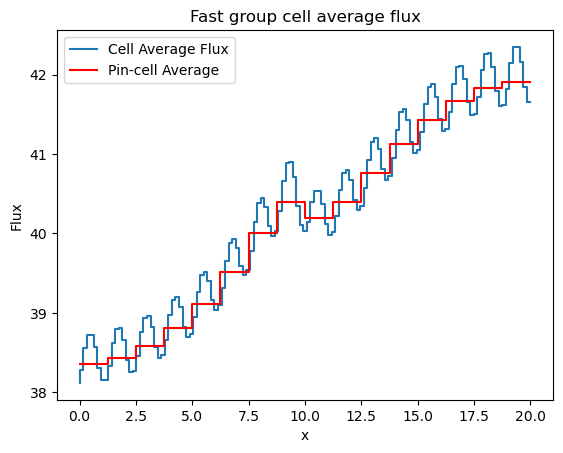

In [1054]:
plt.step(mesh1.mesh_flux, tally1.cell_average_flux[:,0], label="Cell Average Flux")
plt.step(np.linspace(0,20,17), pin_cell_average[:,0], color="r", where='pre', label="Pin-cell Average")
plt.legend()
plt.title("Fast group cell average flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

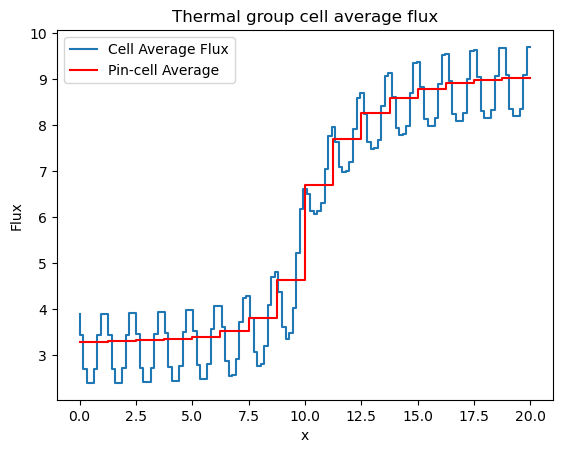

In [1055]:
plt.step(mesh1.mesh_flux, tally1.cell_average_flux[:,1], label="Cell Average Flux")
plt.step(np.linspace(0,20,17), pin_cell_average[:,1], color="r", where='pre', label="Pin-cell Average")
plt.legend()
plt.title("Thermal group cell average flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()


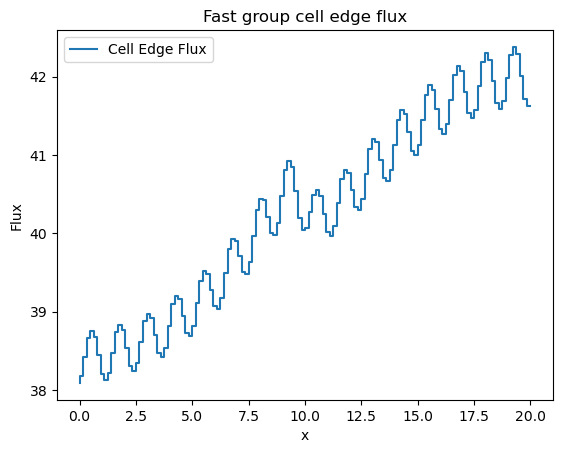

In [1056]:
plt.step(mesh1.mesh_x, tally1.cell_edge_flux[:,0], label="Cell Edge Flux")
plt.legend()
plt.title("Fast group cell edge flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

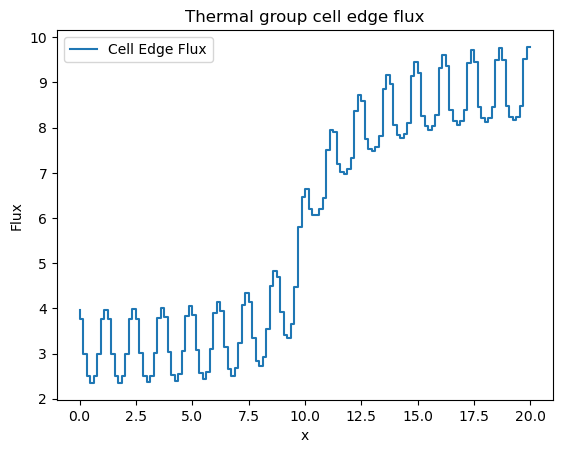

In [1057]:
plt.step(mesh1.mesh_x, tally1.cell_edge_flux[:,1], label="Cell Edge Flux")
plt.legend()
plt.title("Thermal group cell edge flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

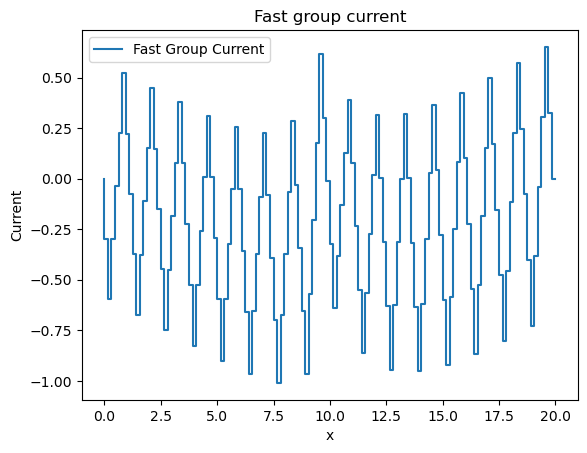

In [1058]:
plt.step(mesh1.mesh_x, tally1.current[:,0], label="Fast Group Current")
plt.legend()
plt.title("Fast group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

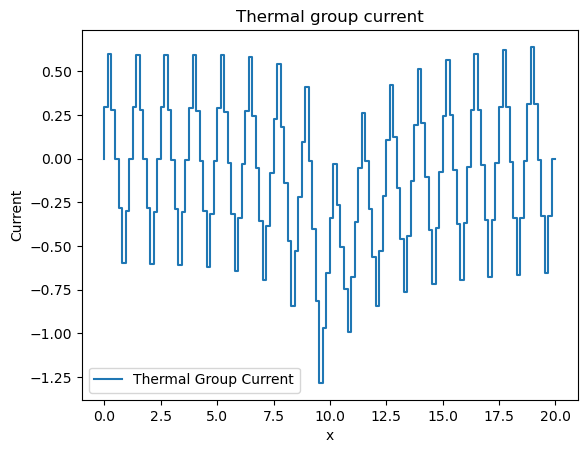

In [1059]:
plt.step(mesh1.mesh_x, tally1.current[:,1], label="Thermal Group Current")
plt.legend()
plt.title("Thermal group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

Problem B

In [1060]:
# materials
mox = material(np.array([0,0.75]), 
              np.array([[0.21,0.04],[0,1.0]]), 
              np.array([0.25,1.25]))

u = material(np.array([0,0.25]), 
              np.array([[0.21,0.04],[0,0.9]]), 
              np.array([0.25,1.1]))

water = material(np.array([0,0]), 
              np.array([[0.17,0.06],[0,1.1]]), 
              np.array([0.25,1.1]))
# cells
cells = []

for i in range(8):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, mox), cell(i+.9375, i+1.25, water)])

for i in range(8, 16):
    i *= 1.25
    cells.extend([cell(i+0, i+.3125, water), cell(i+.3125, i+.9375, u), cell(i+.9375, i+1.25, water)])

# gauss-legendre
U, W = leg.leggauss(10)

# mesh
mesh1 = mesh(128 + 1, 20, "reflective", U, W)

# tally
tally1 = tally(np.zeros((mesh1.Nx-1, 2)), 
                np.zeros((mesh1.Nx, 2)),
                np.zeros((mesh1.Nx, 2)),
                1)

# initialize source
source1 = source(np.zeros_like(mesh1.mesh_flux), 
                np.ones_like(mesh1.mesh_flux))

# initialize bc
bc1 = bc(np.zeros((2, len(mesh1.U))))

In [1061]:
main_loop()

Energy Group:  0 Source iterations:  50
Energy Group:  1 Source iterations:  99
Power iteration:  0
Energy Group:  0 Source iterations:  41
Energy Group:  1 Source iterations:  99
Power iteration:  1
Energy Group:  0 Source iterations:  39
Energy Group:  1 Source iterations:  99
Power iteration:  2
Energy Group:  0 Source iterations:  37
Energy Group:  1 Source iterations:  99
Power iteration:  3
Energy Group:  0 Source iterations:  34
Energy Group:  1 Source iterations:  95
Power iteration:  4
Energy Group:  0 Source iterations:  31
Energy Group:  1 Source iterations:  86
Power iteration:  5
Energy Group:  0 Source iterations:  28
Energy Group:  1 Source iterations:  76
Power iteration:  6
Energy Group:  0 Source iterations:  25
Energy Group:  1 Source iterations:  67
Power iteration:  7
Energy Group:  0 Source iterations:  22
Energy Group:  1 Source iterations:  58
Power iteration:  8
Energy Group:  0 Source iterations:  19
Energy Group:  1 Source iterations:  48
Power iteration:  9


In [1062]:
# get pin cell average
pin_cell_average = get_pin_average(tally1.cell_average_flux)

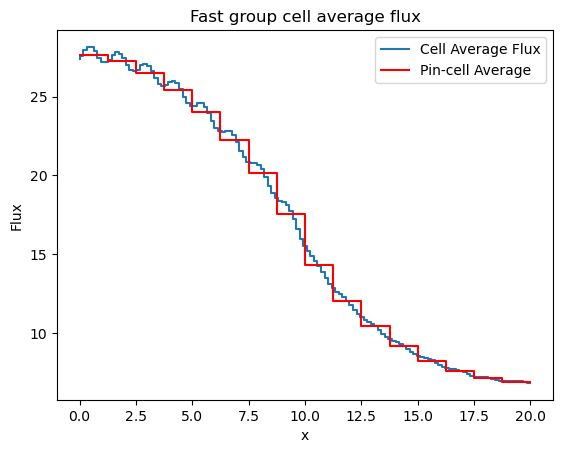

In [1063]:
plt.step(mesh1.mesh_flux, tally1.cell_average_flux[:,0], where='pre', label="Cell Average Flux")
plt.step(np.linspace(0,20,17), pin_cell_average[:,0], color="r", where='pre', label="Pin-cell Average")
plt.legend()
plt.title("Fast group cell average flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

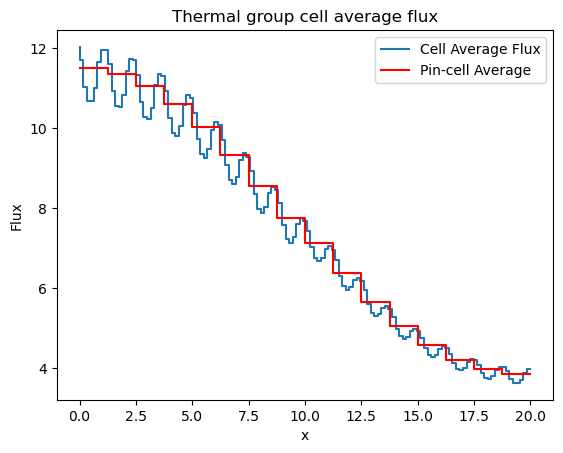

In [1064]:
plt.step(mesh1.mesh_flux, tally1.cell_average_flux[:,1], where='pre', label="Cell Average Flux")
plt.step(np.linspace(0,20,17), pin_cell_average[:,1], color="r", where='pre', label="Pin-cell Average")
plt.legend()
plt.title("Thermal group cell average flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

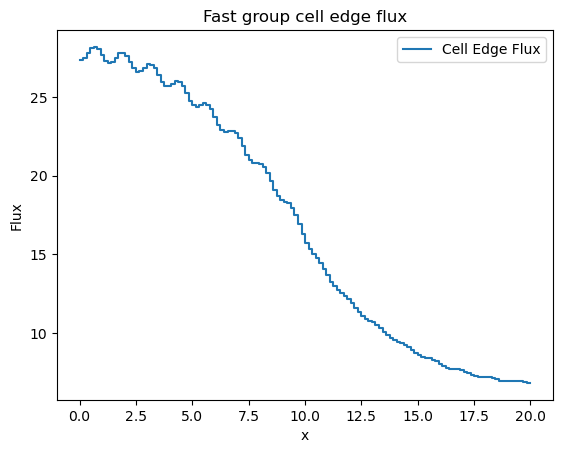

In [1065]:
plt.step(mesh1.mesh_x, tally1.cell_edge_flux[:,0], where='post', label="Cell Edge Flux")
plt.legend()
plt.title("Fast group cell edge flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

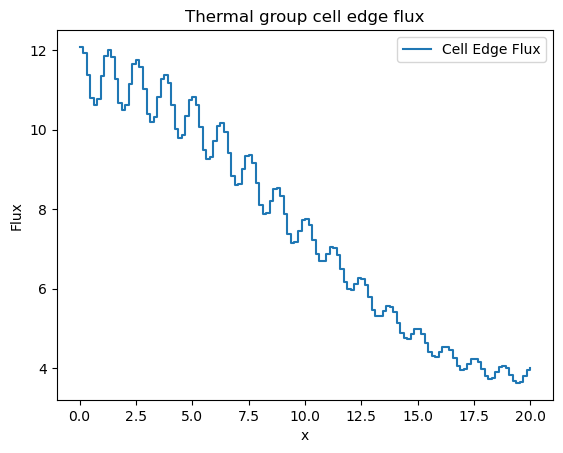

In [1066]:
plt.step(mesh1.mesh_x, tally1.cell_edge_flux[:,1], where='post', label="Cell Edge Flux")
plt.legend()
plt.title("Thermal group cell edge flux")
plt.ylabel("Flux")
plt.xlabel("x")
plt.show()

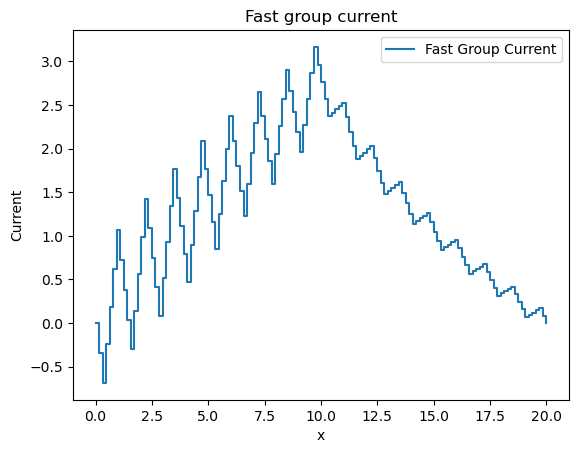

In [1067]:
plt.step(mesh1.mesh_x, tally1.current[:,0], where='post', label="Fast Group Current")
plt.legend()
plt.title("Fast group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()

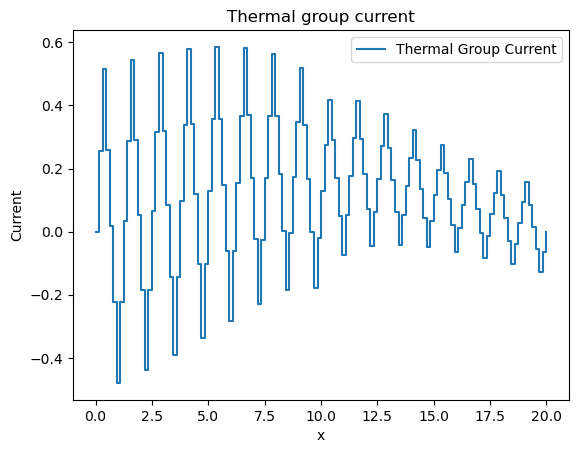

In [1068]:
plt.step(mesh1.mesh_x, tally1.current[:,1], where='post', label="Thermal Group Current")
plt.legend()
plt.title("Thermal group current")
plt.ylabel("Current")
plt.xlabel("x")
plt.show()